Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [56]:
import warnings
warnings.filterwarnings('ignore')

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [2]:
path = './data/austen-brontë-split'

In [3]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            data.append(tokenize(str(text)))
            
    return data

In [7]:
tokens = gather_data(path)

In [10]:
tokens[0][:10]

['giving',
 'fair',
 'companion',
 'account',
 'yesterday',
 'party',
 'friend',
 'cole',
 'come',
 'stilton']

In [14]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [12]:
df['tokens'].head()

Austen_Emma0026         [giving, fair, companion, account, yesterday, ...
Austen_Emma0032         [feels, like, snow, place, party, try, day, di...
CBronte_Villette0086    [pierced, opaque, blackness, stood, bougie, qu...
CBronte_Jane0099        [joke, queer, looks, tell, thing, specially, s...
CBronte_Villette0092    [second, landing, floor, comprising, abode, kn...
Name: tokens, dtype: object

## Follow Along

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [11]:
titles = [t[:-4] for t in os.listdir(path)]

In [12]:
titles[:5]

['Austen_Emma0026',
 'Austen_Emma0032',
 'CBronte_Villette0086',
 'CBronte_Jane0099',
 'CBronte_Villette0092']

In [14]:
len(titles)

813

In [5]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [13]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [17]:
df = pd.DataFrame(index=titles, data={'tokens': tokens})

In [22]:
df.head()

,tokens,author,book,section
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ...",1,Emma,26
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di...",1,Emma,32
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu...",0,Villette,86
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s...",0,Jane,99
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn...",0,Villette,92


In [19]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [20]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [21]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [23]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

In [24]:
streaming_data = doc_stream(path)

In [29]:
print()

### Gensim LDA Topic Modeling

In [35]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [27]:
id2word.token2id['jane']

932

In [30]:
id2word[869]

'england'

In [29]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(869, 3), (1254, 1), (2485, 1), (16851, 1)]

In [31]:
import sys
sys.getsizeof(id2word)

56

In [32]:
len(id2word.keys())

22096

In [36]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)
# no_below takes both count and %, no_above % only

In [37]:
len(id2word.keys())

8103

In [38]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [39]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1)]

In [40]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [41]:
lda.print_topics()

[(0,
  '0.006*"apples" + 0.006*"rochester" + 0.006*"heart" + 0.005*"master" + 0.004*"kept" + 0.004*"face" + 0.004*"william" + 0.004*"miss" + 0.004*"love" + 0.003*"ingram"'),
 (1,
  '0.015*"emma" + 0.011*"miss" + 0.009*"harriet" + 0.008*"weston" + 0.007*"thing" + 0.007*"think" + 0.007*"knightley" + 0.007*"elton" + 0.006*"good" + 0.006*"little"'),
 (2,
  '0.012*"crimsworth" + 0.012*"hunsden" + 0.007*"house" + 0.005*"old" + 0.005*"like" + 0.005*"edward" + 0.004*"good" + 0.004*"man" + 0.004*"thought" + 0.003*"face"'),
 (3,
  '0.007*"dr" + 0.006*"paul" + 0.006*"thought" + 0.006*"john" + 0.004*"know" + 0.004*"day" + 0.004*"hand" + 0.004*"madame" + 0.004*"good" + 0.004*"monsieur"'),
 (4,
  '0.014*"little" + 0.013*"graham" + 0.013*"bretton" + 0.008*"papa" + 0.008*"like" + 0.007*"lucy" + 0.006*"dr" + 0.006*"think" + 0.005*"miss" + 0.005*"polly"'),
 (5,
  '0.006*"like" + 0.005*"little" + 0.004*"know" + 0.004*"day" + 0.004*"thought" + 0.004*"good" + 0.004*"time" + 0.004*"night" + 0.004*"long" + 0

In [42]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [43]:
topics = [' '.join(t[0:5]) for t in words]

In [44]:
for t in topics: 
    print(t)
    print("\n")

apples rochester heart master kept


emma miss harriet weston thing


crimsworth hunsden house old like


dr paul thought john know


little graham bretton papa like


like little know day thought


long like room door time


madame time good like thought


elizabeth know miss time think


marianne elinor sister willoughby darcy


monsieur little frances mdlle english


little time looked thought monsieur


rochester sir jane miss room


like rochester face ingram write


pelet little reuter thought day




## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [45]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [ ]:
# pyLDAvis.gensim.prepare(lda, corpus, id2word)

### Overall Model / Documents

In [47]:
lda[corpus[0]]

[(1, 0.9351618), (8, 0.06256347)]

In [48]:
distro = [lda[d] for d in corpus]

In [49]:
distro[0]

[(1, 0.9348644), (8, 0.06286082)]

In [50]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [51]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [52]:
df.head()

,apples rochester heart master kept,emma miss harriet weston thing,crimsworth hunsden house old like,dr paul thought john know,little graham bretton papa like,like little know day thought,long like room door time,madame time good like thought,elizabeth know miss time think,marianne elinor sister willoughby darcy,monsieur little frances mdlle english,little time looked thought monsieur,rochester sir jane miss room,like rochester face ingram write,pelet little reuter thought day,author
Austen_Emma0026,0.0,0.934508,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.063218,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0032,0.0,0.997457,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Austen
CBronte_Villette0086,0.0,0.000000,0.0,0.0,0.260682,0.737107,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,CBronte
CBronte_Jane0099,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.997619,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,CBronte
CBronte_Villette0092,0.0,0.047911,0.0,0.0,0.220565,0.729722,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,CBronte


In [53]:
df.groupby('author').mean()

,apples rochester heart master kept,emma miss harriet weston thing,crimsworth hunsden house old like,dr paul thought john know,little graham bretton papa like,like little know day thought,long like room door time,madame time good like thought,elizabeth know miss time think,marianne elinor sister willoughby darcy,monsieur little frances mdlle english,little time looked thought monsieur,rochester sir jane miss room,like rochester face ingram write,pelet little reuter thought day
author,,,,,,,,,,,,,,,
Austen,0.000757,0.380244,0.003866,0.000041,0.004168,0.006972,0.001023,0.000000,0.418456,0.174789,0.001788,0.00000,0.002707,0.002528,0.000063
CBronte,0.004425,0.010368,0.015356,0.016857,0.079201,0.540241,0.034784,0.021041,0.022924,0.001064,0.078635,0.02283,0.130268,0.006877,0.012492


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [54]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [57]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [58]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

NameError: name 'coherencemodel' is not defined

In [59]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.657801,2,0
1,-0.726558,8,0
2,-0.711893,14,0
3,-0.794070,20,0
4,-0.768908,26,0


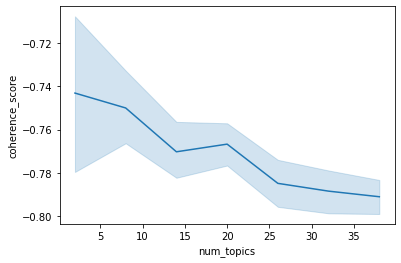

In [60]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [61]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [89]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.02226036),
 (1, 0.022260414),
 (2, 0.022260347),
 (3, 0.022260347),
 (4, 0.022260392),
 (5, 0.0222604),
 (6, 0.022260347),
 (7, 0.35487327),
 (8, 0.022260398),
 (9, 0.022260517),
 (10, 0.022260416),
 (11, 0.022260422),
 (12, 0.3557417),
 (13, 0.022260347),
 (14, 0.022260347)]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [78]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [79]:
test = "Ned asked me a question about England today."

In [80]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [81]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [82]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [129]:
people = get_people(doc_stream(path))

In [126]:
doc = nlp(next(doc_stream(path)))

In [128]:
doc.ents[0].lemma_

'yesterday'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)